# OSMnx demo

Get street networks anywhere in the world from OpenStreetMap data then analyze and visualize them.

More info:

  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)

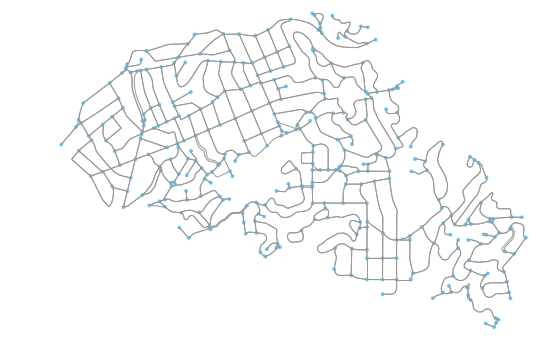

In [2]:
# get a graph for some city
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
fig, ax = ox.plot_graph(G)

In [3]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

4226618.125754957

In [4]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'circuity_avg': 1.1132174687740364,
 'clean_intersection_count': 271,
 'clean_intersection_density_km': 64.11745559615564,
 'edge_density_km': 27019.983941886567,
 'edge_length_avg': 121.49271690041024,
 'edge_length_total': 114203.15388638563,
 'intersection_count': 312,
 'intersection_density_km': 73.81788245756664,
 'k_avg': 5.433526011560693,
 'm': 940,
 'n': 346,
 'node_density_km': 81.86213887922453,
 'self_loop_proportion': 0.006382978723404255,
 'street_density_km': 14057.46246046083,
 'street_length_avg': 121.25617477041556,
 'street_length_total': 59415.52563750362,
 'street_segments_count': 490,
 'streets_per_node_avg': 2.953757225433526,
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 263, 4: 47, 5: 1, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.09826589595375723,
  2: 0.0,
  3: 0.7601156069364162,
  4: 0.13583815028901733,
  5: 0.002890173410404624,
  6: 0.002890173410404624}}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [5]:
# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

avg_neighbor_degree
avg_neighbor_degree_avg
avg_weighted_neighbor_degree
avg_weighted_neighbor_degree_avg
betweenness_centrality
betweenness_centrality_avg
center
closeness_centrality
closeness_centrality_avg
clustering_coefficient
clustering_coefficient_avg
clustering_coefficient_weighted
clustering_coefficient_weighted_avg
degree_centrality
degree_centrality_avg
diameter
eccentricity
pagerank
pagerank_max
pagerank_max_node
pagerank_min
pagerank_min_node
periphery
radius


In [6]:
# pull up some stat's value
more_stats['radius']

2507.2393188271258

In [7]:
# save graph to disk as shapefile (for GIS) or graphml file (for gephi etc)
ox.save_graph_shapefile(G, filename='mynetwork_shapefile')
ox.save_graphml(G, filename='mynetwork.graphml')

## Visualize street centrality

In [8]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

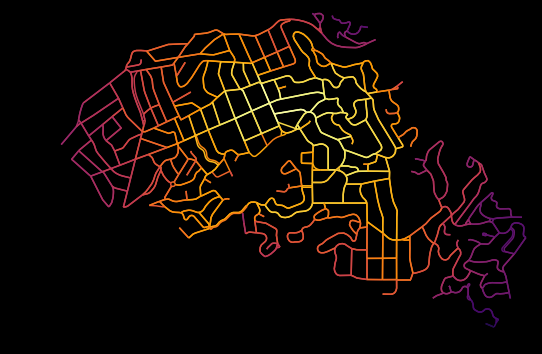

In [9]:
# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=0,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

## Routing

In [10]:
# get the nearest network node to each point
orig_node = ox.get_nearest_node(G, (37.828903, -122.245846))
dest_node = ox.get_nearest_node(G, (37.812303, -122.215006))

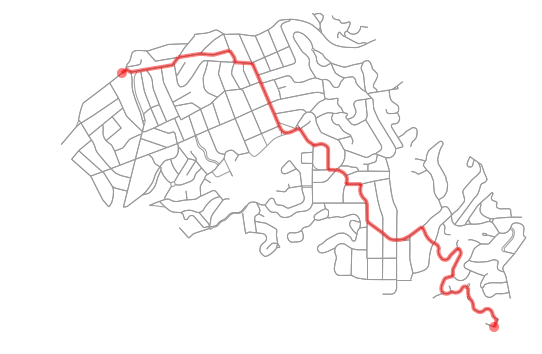

In [11]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [12]:
# how long is our route in meters?
nx.shortest_path_length(G, orig_node, dest_node, weight='length')

4536.120477959521

In [13]:
# how far is it between these two nodes as the crow flies?
ox.great_circle_vec(G.node[orig_node]['y'], G.node[orig_node]['x'],
                    G.node[dest_node]['y'], G.node[dest_node]['x'])

3123.798544245599

## Get networks other ways

make queries less ambiguous to help the geocoder out if it's not finding what you're looking for

In [14]:
# OSM doesn't geocode this simple query to what you might expect...
place = 'San Francisco, California, USA'
G = ox.graph_from_place(place, network_type='drive')

ValueError: Geometry must be a shapely Polygon or MultiPolygon

In [15]:
# let's see what it matches that query string to...
url = 'https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q={}'
url = url.format(place)
response = requests.get(url)
response.json()

[{'boundingbox': ['24.0480117', '24.0493488', '-104.6096919', '-104.6077785'],
  'class': 'highway',
  'display_name': 'San Francisco, San Jorge, California, Durango, 34234, México',
  'geojson': {'coordinates': [[-104.6096919, 24.0480117],
    [-104.6093483, 24.048255],
    [-104.6090254, 24.0484836],
    [-104.6083795, 24.0489408],
    [-104.6080499, 24.0491742],
    [-104.6077785, 24.0493488]],
   'type': 'LineString'},
  'importance': 0.335,
  'lat': '24.0484836',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright',
  'lon': '-104.6090254',
  'osm_id': '139323941',
  'osm_type': 'way',
  'place_id': '105074099',
  'type': 'living_street'}]

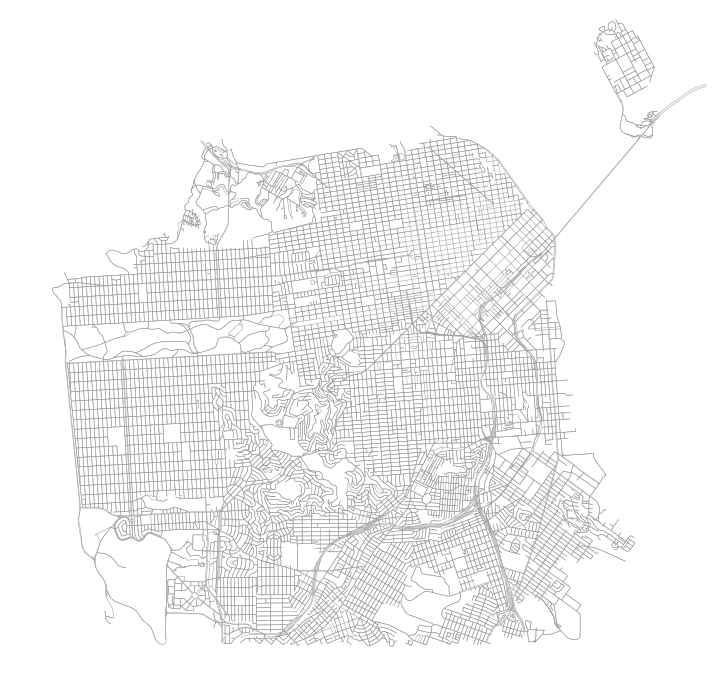

In [16]:
# make query an unambiguous dict to help the geocoder find specifically what you're looking for
place = {'city' : 'San Francisco',
         'state' : 'California',
         'country' : 'USA'}
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G, fig_height=12, node_size=0, edge_linewidth=0.5)

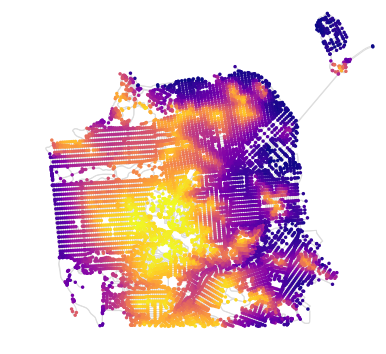

In [17]:
# add elevation to nodes automatically, calculate edge grades, plot network
from keys import google_elevation_api_key
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)
nc = ox.get_node_colors_by_attr(G, 'elevation', cmap='plasma')
fig, ax = ox.plot_graph(G, fig_height=6, node_color=nc, node_size=12, node_zorder=2, edge_color='#dddddd')

example: create impedance functions to route around hills: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/12-node-elevations-edge-grades.ipynb

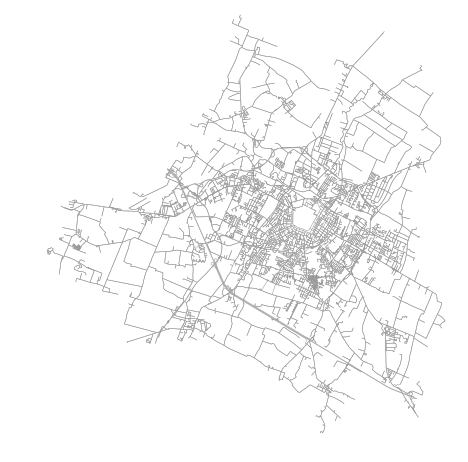

In [18]:
# you can get networks anywhere in the world
G = ox.graph_from_place('Modena, Italy', network_type='drive_service')
fig, ax = ox.plot_graph(G, fig_height=8, node_size=0, edge_linewidth=0.5)

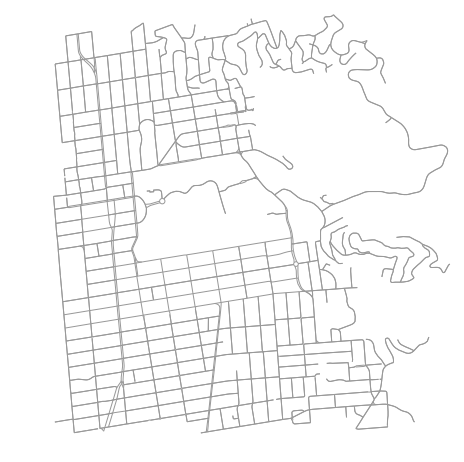

In [19]:
# or get network by coordinates, bounding box, or any custom polygon shape
# useful when OSM just doesn't have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609 #meters
G = ox.graph_from_point(wurster_hall, distance=one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, fig_height=8, node_size=0)

examples of getting networks by coordinates, bounding box, or any custom polygon shape: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/01-overview-osmnx.ipynb

## Get other infrastructure types

like rail or electric grids

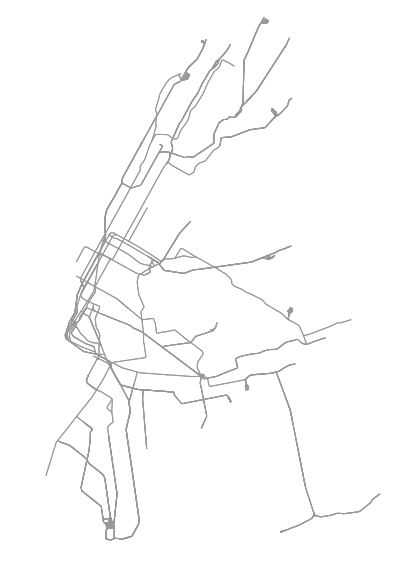

In [20]:
# get rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should prob download a station adjacency matrix elsewhere
G = ox.graph_from_place('New York City, New York',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        network_type='none', infrastructure='way["railway"~"subway"]')

fig, ax = ox.plot_graph(G, fig_height=10, node_size=0)